In [1]:
!nvidia-smi

Wed Apr  7 01:03:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os

In [4]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 12.4MB/s 
     |████████████████████████████████| 460kB 56.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [5]:
from konlpy.tag import Okt
from gensim.models import Word2Vec, KeyedVectors

In [6]:
import tensorflow as tf

In [7]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import models, Input, Model
from keras import optimizers
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Concatenate, Dropout

In [8]:
from sklearn.model_selection import train_test_split

## 1. Data Load

In [9]:
url = "https://raw.githubusercontent.com/Kwang-wan/Project_AI/main/data/Trash_Comment.csv"

data = pd.read_csv(url)

data.head()

,text,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,1
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,1
2,짱깨 꺼라ㅡ패쓰,1
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0


## 2. Data Cleansing

In [10]:
def clean(data) :
  data['text'] = data['text'].str.replace("[^가-힣A-Za-z0-9(),!?\'\`]" , " ")
  data['text'] = data['text'].str.replace("," , " , ")  
  data['text'] = data['text'].str.replace("!" , " ! ")
  data['text'] = data['text'].str.replace("\(" , " \( ") 
  data['text'] = data['text'].str.replace("\)" , " \) ")
  data['text'] = data['text'].str.replace("?" , " ? ")   
  data['text'] = data['text'].str.replace("\s{2,}" , " ")  
  data['text'] = data['text'].str.replace("\'{2,}" , "\'")  
  data['text'] = data['text'].str.replace("\'" , "") 

In [11]:
clean(data)

In [12]:
data.head()

,text,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다 2년전인가 ? ? 좀 신선했었지 ...,1
1,씨바알 노무노무 술프노 오늘 저녁은 꽂등심이다,1
2,짱깨 꺼라 패쓰,1
3,그들의 사생활 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨소용...,0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0


### 1) 불용어지정 및 형태소분석, 토큰화

In [13]:
stopwords = ['의', '가', '이', '은', '들', '는',
             '좀', '잘', '걍', '과', '도',
             '를', '으로', '자', '에', '와', '한', '하다']

In [16]:
%%time

okt = Okt()
tokenized_data = []

for sentence in data['text'] :
  temp_X = okt.morphs(sentence, stem = True) # 토큰화(형태소 별로 나눠짐)
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  tokenized_data.append(temp_X)

CPU times: user 1min 25s, sys: 689 ms, total: 1min 25s
Wall time: 1min 12s


### 2) 리뷰 길이 확인

In [18]:
print('댓글 최대 길이: ' , max(len(l) for l in tokenized_data))
print('댓글 평균 길이: ' , sum(map(len, tokenized_data))/len(tokenized_data))

댓글 최대 길이:  408
댓글 평균 길이:  12.529868049407698


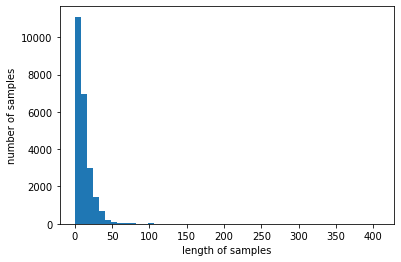

In [19]:
plt.hist([len(f) for f in tokenized_data] , bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 3) 50 단어 이하로 단어제한 & 패딩

In [ ]:
sentences_new = []

for sentence in tokenized_data:
  sentences_new.append([word for word in sentence][:50])

tokenized_data = sentences_new

for i in range(5) :
  print(tokenized_data[i]) 

['이종석', '한효주', '나오다', '드라마', '이후', '로', '드라마', '안', '보다', '2년', '전인가', '?', '?', '신선하다', '근데', '이렇다', '개막', '장', '드라마', '도대체', '누가', '보다', '면', '변태', '보다', '것', '이다', '정상', '적', '인', '사람', '채널', '을', '돌리다', '되다']
['씨', '바알', '노무', '노무', '술프노', '오늘', '저녁', '꽂다', '등심', '이다']
['짱깨', '끄다', '패쓰']
['그', '사생활', '고인', '되다', '설리', '위', '모두', '조용하다', '지금', '누굴', '탓', '무슨', '소', '용이', '있다']
['아무리', '법', '뭣같아', '무슨', '자격', '개인', '신상', '정보', '불', '특정', '다수', '에게', '공개', '도저히', '이해', '안되다', '법', '을', '바꾸다', '위해', '노력', '저런', '능력', '불법', '적', '인', '일', '을', '공공', '이익', '포장', '말다']


In [ ]:
%%time

tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(tokenized_data)

X = tokenizer.texts_to_sequences(tokenized_data)
X = pad_sequences(X)

print(X[:5])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0  2226  1606    26   101   785    12   101    11     3
   1223  6337     1     1  2016    87    90  3943   493   101   647   200
      3    52  2927     3    60    17   772    55    49    16   847     4
    516     8]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0    80  6338  1518  1518  9319   280  2734  2227
   9320    17]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0   553
    141  9321]
 [    0     0     0     0     0     0     0     0     0     0     0

## 3. X, y split

In [14]:
# y shape 맞춰주기
y = np.array([[label] for label in data['label']])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state = 2046)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18976, 50), (4745, 50), (18976, 1), (4745, 1))

## 4. Modeling

### 1) 모델링에 필요한 함수 정의

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### 2) 모델 설계

In [ ]:
vocab_size = 20000  # 빈도수 상위 2만개의 단어만 사용
max_len = 50  # 문장의 최대 길이

In [ ]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

In [ ]:
inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile("adam",
              "sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
593/593 [==============================] - 5s 9ms/step - loss: 0.2249 - accuracy: 0.9131 - val_loss: 0.4238 - val_accuracy: 0.8331
Epoch 2/10
593/593 [==============================] - 5s 9ms/step - loss: 0.1532 - accuracy: 0.9416 - val_loss: 0.4746 - val_accuracy: 0.8384
Epoch 3/10
593/593 [==============================] - 5s 9ms/step - loss: 0.1083 - accuracy: 0.9567 - val_loss: 0.5438 - val_accuracy: 0.8356
Epoch 4/10
593/593 [==============================] - 5s 9ms/step - loss: 0.0843 - accuracy: 0.9623 - val_loss: 0.7584 - val_accuracy: 0.8331
Epoch 5/10
593/593 [==============================] - 5s 9ms/step - loss: 0.0676 - accuracy: 0.9678 - val_loss: 0.8082 - val_accuracy: 0.8335
Epoch 6/10
593/593 [==============================] - 5s 9ms/step - loss: 0.0566 - accuracy: 0.9718 - val_loss: 0.8663 - val_accuracy: 0.8348
Epoch 7/10
593/593 [==============================] - 5s 9ms/step - loss: 0.0494 - accuracy: 0.9744 - val_loss: 0.9788 - val_accuracy: 0.8331
Epoch 

## 5. 성능 확인

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

print('Loss = {:.5f}' .format(loss))
print('Accuracy = {:.5f}' .format(accuracy))

149/149 [==============================] - 0s 3ms/step - loss: 1.1933 - accuracy: 0.8341
Loss = 1.19333
Accuracy = 0.83414
